# Random Forest  on CIFAR-10

## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


## Loading Data & printing shapes

## Data reshaping

In [2]:
# get some random training images
dataiter = iter(trainloader)
trainset, y_train = dataiter.next()
testiter = iter(testloader)
testset, y_test = testiter.next()

ten = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

x_train = trainset.reshape((50000, 3072))
y_train1 = list(y_train.flatten())
x_test = testset.reshape((10000, 3072))
y_test1 = list(y_test.flatten())

print("[after reshaping]")
print("trainig   data shape  : ",x_train.shape ,x_train.shape[0], 'examples')
print("testing   data shape  : ",x_test.shape,x_test.shape[0], 'examples')


[after reshaping]
trainig   data shape  :  torch.Size([50000, 3072]) 50000 examples
testing   data shape  :  torch.Size([10000, 3072]) 10000 examples


## Data exploration
First data visualisation without any pre-processing on it.
Printing 10 first images from the training set. 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
figure1 = plt.figure(figsize=(15,5))
for i in range(1,5):
    single_img = np.array(x_train[i])
    single_img_reshaped = np.transpose(np.reshape(single_img,(3, 32,32)), (1,2,0))
    images = figure1.add_subplot(2, 5, i , xticks=[], yticks=[])
    images.imshow(single_img_reshaped)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000000992AA606A8> (for post_execute):


ValueError: Floating point image RGB values must be in the 0..1 range.

ValueError: Floating point image RGB values must be in the 0..1 range.

# RF: Training our model

In [4]:
import random
from sklearn import ensemble
n_samples=len(x_train)
n_samples2=len(x_test)

X=x_train.reshape(n_samples,-1)
Y=y_train
x=X.numpy()
y=Y.numpy()
print(x.shape)
print(y.shape)
X2=x_test.reshape(n_samples2,-1)
Y2=y_test
xt=X2.numpy()
yt=Y2.numpy()
print(xt.shape)
print(yt.shape)

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


In [5]:
sample_index=random.sample(range(len(x)),int(len(x)/5))
valid_index=[i for i in range(len(x)) if i not in sample_index]
print(len(sample_index))
print(len(valid_index))

10000
40000


In [6]:
sample_images=[x[i] for i in sample_index]
valid_images=[x[i] for i in valid_index]
print(len(sample_images))
print(len(valid_images))

10000
40000


In [7]:
sample_target=[y[i] for i in sample_index]
valid_target=[y[i] for i in valid_index]

In [8]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features
               }
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt']}


In [9]:
from sklearn.model_selection import GridSearchCV
# First create the base model to tune
rf = ensemble.RandomForestClassifier()
# using 3 fold cross validation, 
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, refit='AUC', return_train_score=True, n_jobs = -1)
# Fit the random search model
rf_random.fit(sample_images, sample_target)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score=True,
       scoring=None, verbose=0)

In [10]:
print("Best estimator found by grid search:")
print(rf_random.best_estimator_)

Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [11]:
n_tree=[100,400,700,1000,1300,1600,2000]
ascore=[]
for n in n_tree:
    classifier=ensemble.RandomForestClassifier(n_estimators=n,max_features="sqrt")
    classifier.fit(sample_images,sample_target)
    ascore.append(classifier.score(valid_images,valid_target))
print('Scores:',ascore)


Scores: [0.4151, 0.433625, 0.437, 0.43935, 0.44005, 0.437875, 0.44025]


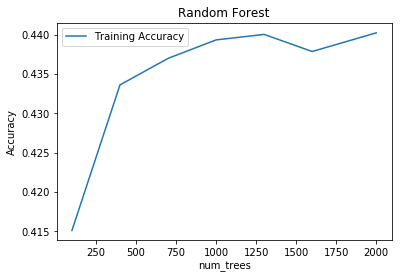

In [12]:
#Generate plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Random Forest')
plt.plot(n_tree, ascore, label='Training Accuracy')
plt.legend()
plt.xlabel('num_trees')
plt.ylabel('Accuracy')
plt.show()

In [13]:
classifier=ensemble.RandomForestClassifier(n_estimators=2000,max_features="sqrt")

In [14]:
classifier.fit(sample_images,sample_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
y_pred=classifier.predict(xt)

In [17]:
from sklearn.metrics import accuracy_score
print('Accuracy: {}'.format(accuracy_score(yt, y_pred)))

Accuracy: 0.4471
